In [ ]:
import tensorflow as tf
import glob

In [ ]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [ ]:
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
import tensorflow_datasets as tfds

from IPython.display import clear_output
import matplotlib.pyplot as plt

# Preprocessing Data Organization Steps 

# U- Net Model Defintion

In [ ]:
OUTPUT_CHANNELS = 4 #four different classes technically, but one of the classes can be pixel value black 

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)
  last = tf.keras.layers.Reshape((128*128, 4), input_shape=(128,128,4))
  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

# Model Training

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Visualize the Model

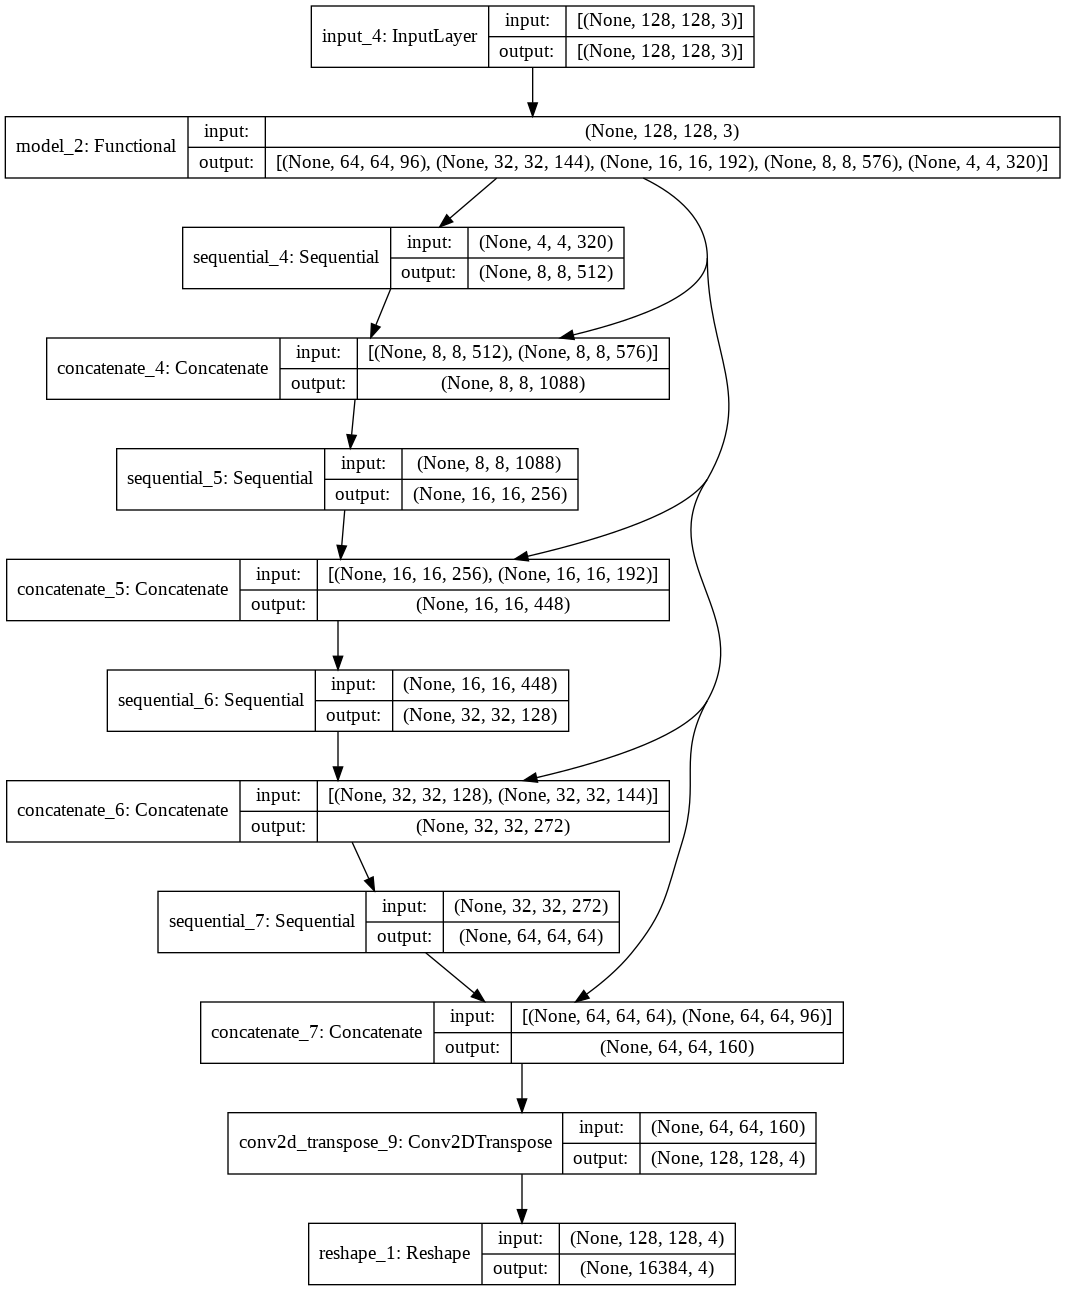

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

## Load Training Data

In [ ]:
#validation training data for examples
Xtrain = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/XtrainDataResized/Xdata_1_resized.npy')
Ytrain = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/YtrainDataResized/Ylabels_1_resized.npy')
Xtrain_val = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/XtestDataResized/Xdata_9_resized.npy')
Ytrain_val = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/YtestDataResized/Ylabels_9_resized.npy')

### Display Training Results as Updated and Show a Few Example Images Before Training

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))
  title = ['Input Image', 'True Mask', 'Predicted Mask']
  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow((display_list[i]), vmin=0, vmax=3)
    plt.axis('off')
  plt.show()

In [ ]:
def create_mask(pred_mask):

  pred_mask = np.reshape(pred_mask, (128,128,4))
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask

In [ ]:
def show_predictions(X,Y, num=0):

  x = X[num,:,:,:]
  pred_mask = model.predict(x[tf.newaxis,...])
  pred_mask = create_mask(pred_mask)
  display([X[num,:,:,:], Y[num,:,:,0], pred_mask[:,:,0]])

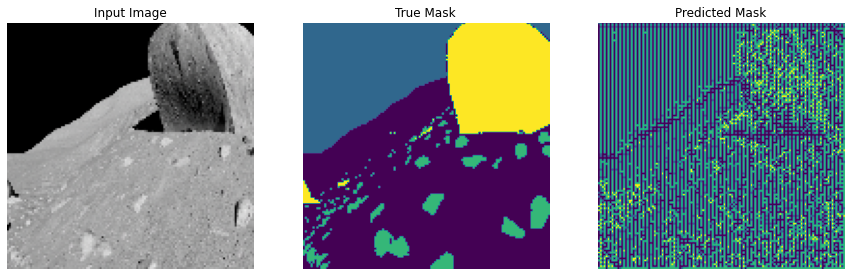

In [ ]:
show_predictions(Xtrain_val, Ytrain_val,22)

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    #clear_output(wait=True)
    show_predictions(Xtrain_val, Ytrain_val,22)
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

## Model Fitting

# Set Up Training and Validation Parameters

In [ ]:
#load data 
FileDirX= '/content/drive/MyDrive/CS 738/Project/Batched Data/XtrainDataResized/*.npy'
FileDirY= '/content/drive/MyDrive/CS 738/Project/Batched Data/YtrainDataResized/*.npy'

Files_ListX = glob.glob(FileDirX)
Files_ListY = glob.glob(FileDirY)

Files_ListX.sort()
Files_ListY.sort()

In [ ]:
#initialize class weights using sample weights method calculated during the pre-processing
#cl_weights = {}
#cl_weights[0]=.3290
#cl_weights[1] = 1.283
#cl_weights[2] =10.337
#cl_weights[3] = 11.774

#without class weighting
cl_weights = {}
cl_weights[0] = 1
cl_weights[1] = 1
cl_weights[2] = 1
cl_weights[3] = 1

#biasing the model towards large and small rocks 
#cl_weights = {}
#cl_weights[0]=.3290
#cl_weights[1] = 1.283
#cl_weights[2] =10.337 * 1.5
#cl_weights[3] = 11.774 * 1.5

#GT Model
cl_weights = {}
cl_weights[0]=.339
cl_weights[1] = 1.284
cl_weights[2] =5.337
cl_weights[3] = 11.468



Xtrain_val = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/XtestDataResized/Xdata_9_resized.npy')
Ytrain_val = np.load('/content/drive/MyDrive/CS 738/Project/Batched Data/YtestDataResized/Ylabels_9_resized.npy')


#reformat the validation data to fit with the model architecture
Ytrain_valNew = np.zeros((Ytrain_val.shape[0], 128*128,1))
for k in range(0,Ytrain.shape[0]):
  imLabels = Ytrain_val[k,:,:,:] # load the label for the training image
  imLabels = imLabels.reshape((128*128))
  Ytrain_valNew[k,:] = imLabels.reshape((128*128,1))


#load all the training data
for k in range(0,len(Files_ListX)):
  if (k==1):
    #initialize Xtrain and Ytrain on firt iteration to make concatenation possible
    Xtrain = np.load(Files_ListX[k])
    Ytrain = np.load(Files_ListY[k])
  else:
    dataX = np.load(Files_ListX[k])
    dataY = np.load(Files_ListY[k])
    Xtrain = np.concatenate((Xtrain, dataX), axis=0) # create large training set
    Ytrain = np.concatenate((Ytrain, dataY), axis=0)
  
#get the sample weights to avoid overfitting on background/sky
sample_weights = np.zeros((Xtrain.shape[0],128*128))
YtrainNew = np.zeros((Ytrain.shape[0], 128*128,1)) # reshape Y train to fit model architecture

for k in range(0,Ytrain.shape[0]): # build proper sample weights
  imLabels = Ytrain[k,:,:,:] # load the label for the training image
  imLabels = imLabels.reshape((128*128))
  UpdateIndices = np.where(imLabels == 0)
  sample_weights[k,UpdateIndices] = cl_weights[0]
  UpdateIndices = np.where(imLabels == 1)
  sample_weights[k,UpdateIndices] = cl_weights[1]
  UpdateIndices = np.where(imLabels == 2)
  sample_weights[k,UpdateIndices] = cl_weights[2]
  UpdateIndices = np.where(imLabels == 3)
  sample_weights[k,UpdateIndices] = cl_weights[3]
  YtrainNew[k,:] = imLabels.reshape((128*128,1))


In [ ]:
TRAIN_LENGTH = Xtrain.shape[0]
VAL_LENGTH = Xtrain_val.shape[0]
BATCH_SIZE = 256 # 64
#BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 5
VAL_SUBSPLITS = 5
VALIDATION_STEPS = VAL_LENGTH//BATCH_SIZE//VAL_SUBSPLITS
VALIDATION_BATCH_SIZE = Xtrain_val.shape[0]

Epoch 1/5
27/27 [==============================] - 642s 24s/step - loss: 1.2572 - accuracy: 0.4418 - val_loss: 0.7075 - val_accuracy: 0.7877


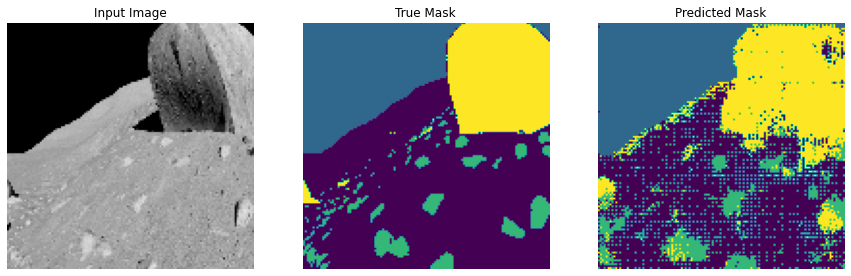


Sample Prediction after epoch 1

Epoch 2/5
27/27 [==============================] - 641s 24s/step - loss: 0.6356 - accuracy: 0.7879 - val_loss: 0.4646 - val_accuracy: 0.8813


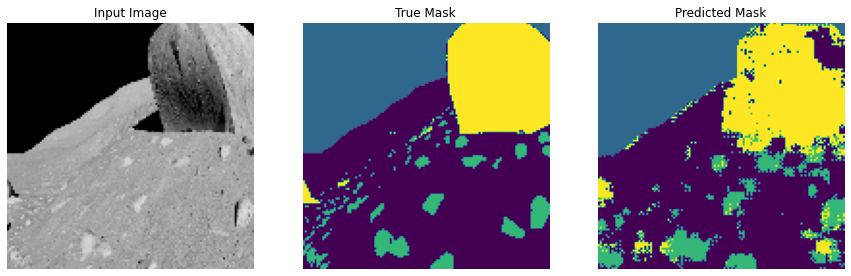


Sample Prediction after epoch 2

Epoch 3/5
27/27 [==============================] - 637s 24s/step - loss: 0.5085 - accuracy: 0.8097 - val_loss: 0.3493 - val_accuracy: 0.9157


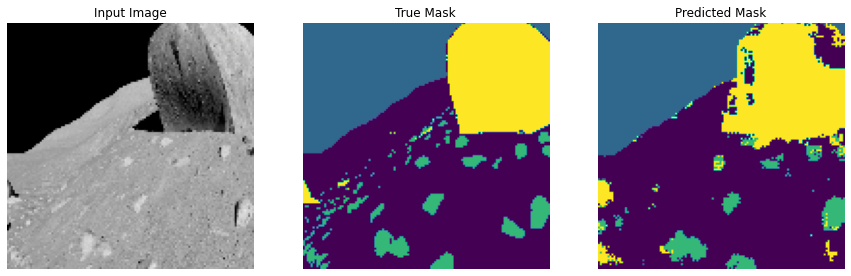


Sample Prediction after epoch 3

Epoch 4/5
27/27 [==============================] - 638s 24s/step - loss: 0.4757 - accuracy: 0.8145 - val_loss: 0.3473 - val_accuracy: 0.9121


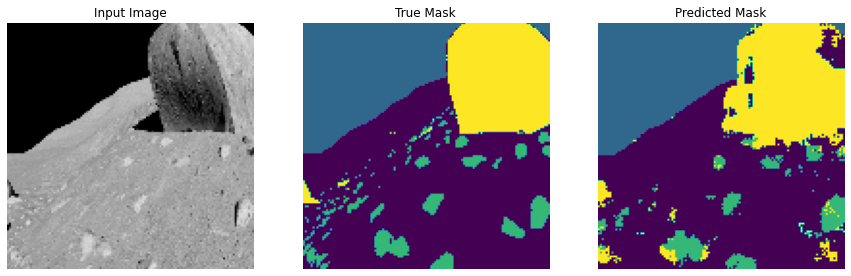


Sample Prediction after epoch 4

Epoch 5/5
27/27 [==============================] - 637s 24s/step - loss: 0.4534 - accuracy: 0.8179 - val_loss: 0.3486 - val_accuracy: 0.9041


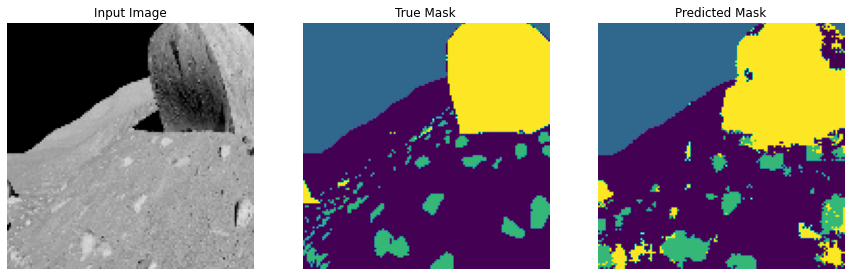


Sample Prediction after epoch 5



In [ ]:
#perform training (using pixel weighting to get even class balance)
model_history = model.fit(x=Xtrain,y=YtrainNew, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_batch_size=VALIDATION_BATCH_SIZE,
                          validation_data= tuple((Xtrain_val, Ytrain_valNew)),
                          sample_weight = sample_weights,
                          shuffle = True,
                          callbacks=[DisplayCallback()])
  

## Plot Validation Curve

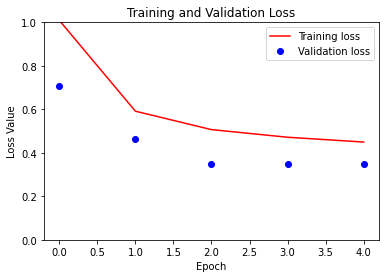

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
# serialize to JSON for reloading purposes later

##model with class weighting
json_file_path = '/content/drive/MyDrive/CS 738/Project/My Trained Models/Unet_trained_withClassweights.json'
h5_file = '/content/drive/MyDrive/CS 738/Project/My Trained Models/Unet_trained_withClassWeights_MW.h5'

#json_file_path = '/content/drive/MyDrive/CS 738/Project/My Trained Models/Unet_trained_withoutClassweights.json'
#h5_file = '/content/drive/MyDrive/CS 738/Project/My Trained Models/Unet_trained_withoutClassWeights_MW.h5'

##model with rock bias class weighting
#json_file_path = '/content/drive/MyDrive/CS 738/Project/My Trained Models/Unet_trained_with_1-5_Classweights.json'
#h5_file = '/content/drive/MyDrive/CS 738/Project/My Trained Models/Unet_trained_with_1-5_ClassWeights_MW.h5'

#model with GT Renders
#json_file_path = '/content/drive/MyDrive/CS 738/Project/My Trained Models/Unet_trained_GT_with_Classweights.json'
#h5_file = '/content/drive/MyDrive/CS 738/Project/My Trained Models/Unet_trained_GT_with_ClassWeights_MW.h5'

json_file = model.to_json()
with open(json_file_path, "w") as file:
   file.write(json_file)
# serialize weights to HDF5
model.save_weights(h5_file)

print("Model Saved Successfully")

Model Saved Successfully


In [ ]:
whos

Variable                Type             Data/Info
--------------------------------------------------
BATCH_SIZE              int              256
DisplayCallback         type             <class '__main__.DisplayCallback'>
EPOCHS                  int              5
FileDirX                str              /content/drive/MyDrive/CS<...>h/XtrainDataResized/*.npy
FileDirY                str              /content/drive/MyDrive/CS<...>h/YtrainDataResized/*.npy
Files_ListX             list             n=9
Files_ListY             list             n=9
OUTPUT_CHANNELS         int              4
STEPS_PER_EPOCH         int              27
TRAIN_LENGTH            int              7103
UpdateIndices           tuple            n=1
VALIDATION_BATCH_SIZE   int              888
VALIDATION_STEPS        int              0
VAL_LENGTH              int              888
VAL_SUBSPLITS           int              5
Xtrain                  ndarray          7103x128x128x3: 349126656 elems, type `float32`, 139650